In [1]:
import pandas as pd
import numpy as np

# Load data
fraud_data = pd.read_csv('../data/raw/Fraud_Data.csv')
ip_to_country = pd.read_csv('../data/raw/IpAddress_to_Country.csv')

# Function to convert IP string to integer
def ip_to_int(ip_address):
    try:
        parts = ip_address.split('.')
        return (int(parts[0]) << 24) + (int(parts[1]) << 16) + (int(parts[2]) << 8) + int(parts[3])
    except:
        return 0

fraud_data['ip_address'] = fraud_data['ip_address'].apply(ip_to_int)

In [3]:
# 1. Ensure the IP columns are the exact same type (float64 is safest for large IPs)
fraud_data['ip_address'] = fraud_data['ip_address'].astype(float)
ip_to_country['lower_bound_ip_address'] = ip_to_country['lower_bound_ip_address'].astype(float)

# 2. Re-sort just to be safe (merge_asof requires sorted keys)
fraud_data = fraud_data.sort_values('ip_address')
ip_to_country = ip_to_country.sort_values('lower_bound_ip_address')

# 3. Perform the merge again
df_merged = pd.merge_asof(
    fraud_data, 
    ip_to_country, 
    left_on='ip_address', 
    right_on='lower_bound_ip_address'
)

# 4. Final validation
df_merged['country'] = np.where(
    df_merged['ip_address'] <= df_merged['upper_bound_ip_address'], 
    df_merged['country'], 
    'Unknown'
)

In [4]:
# Convert to datetime
df_merged['signup_time'] = pd.to_datetime(df_merged['signup_time'])
df_merged['purchase_time'] = pd.to_datetime(df_merged['purchase_time'])

# 1. Time since signup (in seconds)
df_merged['time_since_signup'] = (df_merged['purchase_time'] - df_merged['signup_time']).dt.total_seconds()

# 2. Time-based features
df_merged['hour_of_day'] = df_merged['purchase_time'].dt.hour
df_merged['day_of_week'] = df_merged['purchase_time'].dt.dayofweek

# 3. Transaction Velocity (Count of occurrences of the same device)
df_merged['device_count'] = df_merged.groupby('device_id')['device_id'].transform('count')

Non-Fraud: 90.64%
Fraud: 9.36%


C:\Users\Mer\AppData\Local\Temp\ipykernel_10236\2638988717.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='class', data=df_merged, palette='viridis')


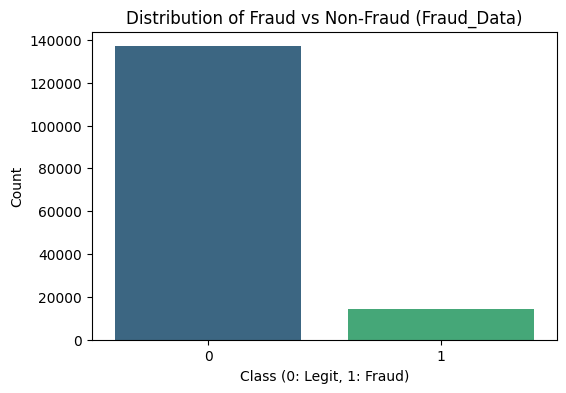

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate fraud percentages
fraud_counts = df_merged['class'].value_counts(normalize=True) * 100
print(f"Non-Fraud: {fraud_counts[0]:.2f}%")
print(f"Fraud: {fraud_counts[1]:.2f}%")

# Plot Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='class', data=df_merged, palette='viridis')
plt.title('Distribution of Fraud vs Non-Fraud (Fraud_Data)')
plt.xlabel('Class (0: Legit, 1: Fraud)')
plt.ylabel('Count')
plt.show()

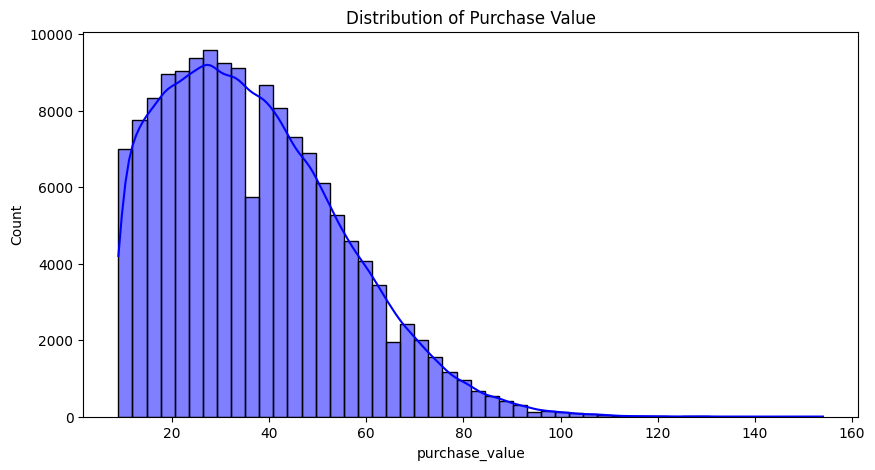

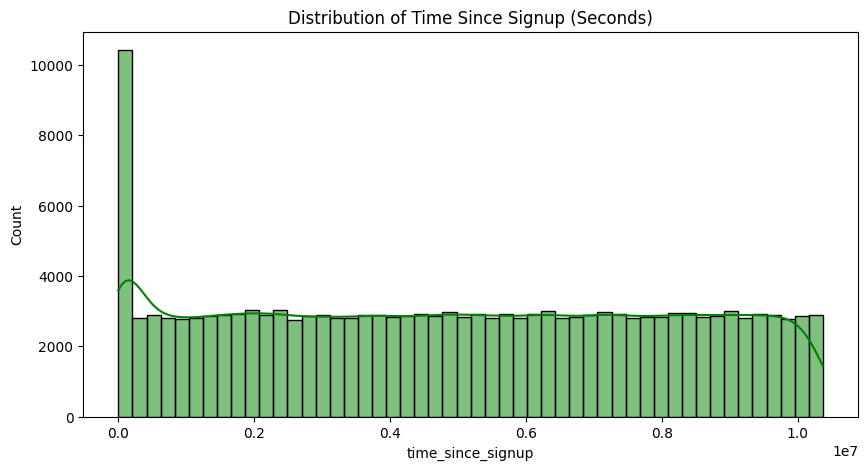

In [6]:
# Distribution of Purchase Value
plt.figure(figsize=(10, 5))
sns.histplot(df_merged['purchase_value'], bins=50, kde=True, color='blue')
plt.title('Distribution of Purchase Value')
plt.show()

# Distribution of Time Since Signup
plt.figure(figsize=(10, 5))
sns.histplot(df_merged['time_since_signup'], bins=50, kde=True, color='green')
plt.title('Distribution of Time Since Signup (Seconds)')
plt.show()

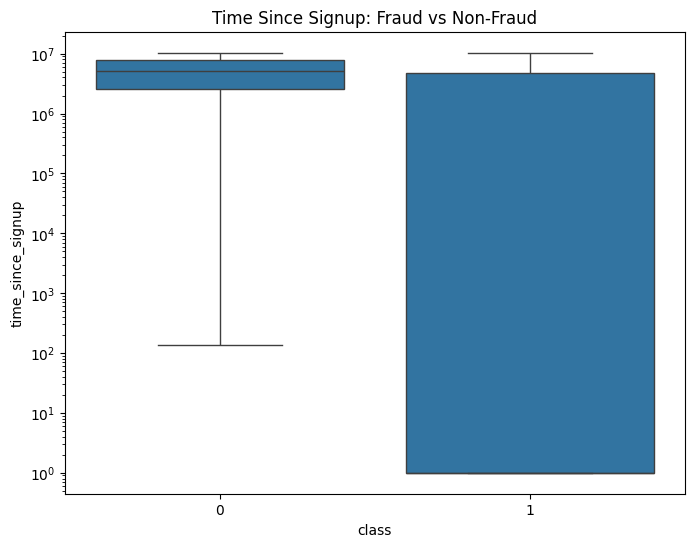

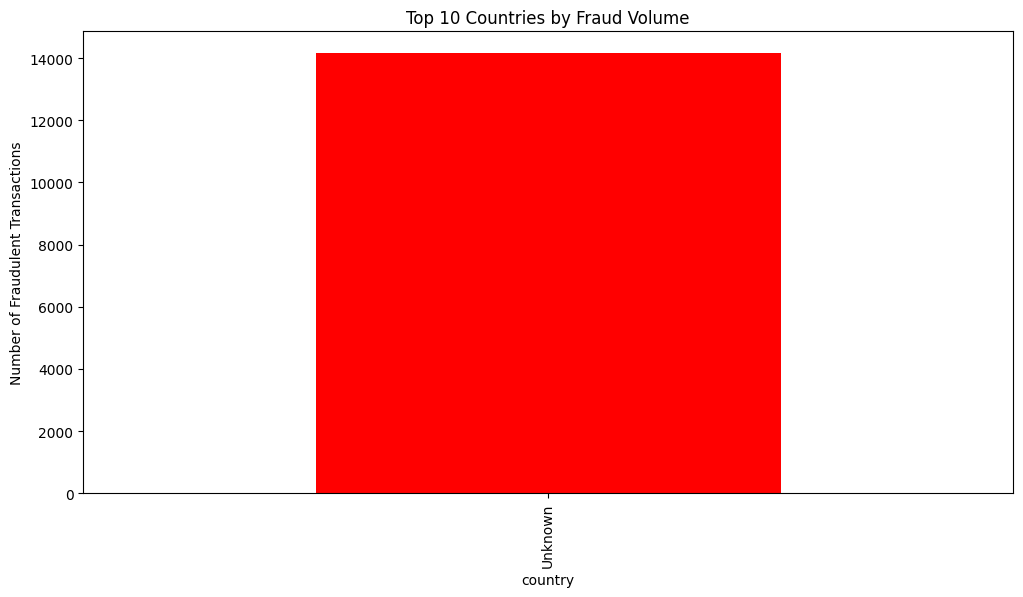

In [7]:
# Boxplot: Time Since Signup vs Class
plt.figure(figsize=(8, 6))
sns.boxplot(x='class', y='time_since_signup', data=df_merged)
plt.title('Time Since Signup: Fraud vs Non-Fraud')
plt.yscale('log') # Log scale helps see differences if values vary widely
plt.show()

# Top 10 Countries with Most Fraud
fraud_by_country = df_merged[df_merged['class'] == 1]['country'].value_counts().head(10)
plt.figure(figsize=(12, 6))
fraud_by_country.plot(kind='bar', color='red')
plt.title('Top 10 Countries by Fraud Volume')
plt.ylabel('Number of Fraudulent Transactions')
plt.show()

Credit Card Legit: 99.8273%
Credit Card Fraud: 0.1727%


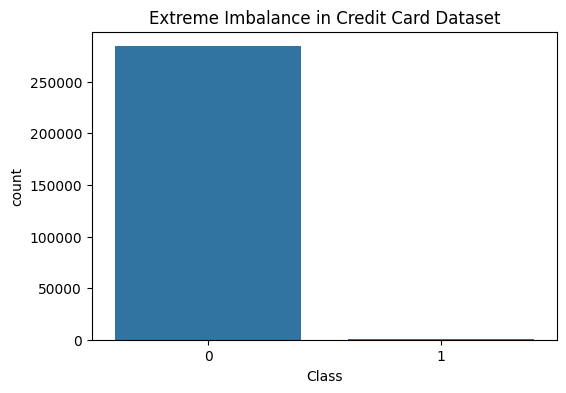

In [8]:
# Load the credit card data
credit_card = pd.read_csv('../data/raw/creditcard.csv')

# 1. Check Imbalance
cc_counts = credit_card['Class'].value_counts(normalize=True) * 100
print(f"Credit Card Legit: {cc_counts[0]:.4f}%")
print(f"Credit Card Fraud: {cc_counts[1]:.4f}%")

# 2. Visualize the massive gap
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=credit_card)
plt.title('Extreme Imbalance in Credit Card Dataset')
plt.show()

In [9]:
# Check for missing values and duplicates
for name, df in [('Fraud Data', df_merged), ('Credit Card', credit_card)]:
    print(f"--- {name} ---")
    print(f"Missing values:\n{df.isnull().sum()}\n")
    print(f"Duplicates: {df.duplicated().sum()}")
    # Drop duplicates if any
    df.drop_duplicates(inplace=True)

--- Fraud Data ---
Missing values:
user_id                        0
signup_time                    0
purchase_time                  0
purchase_value                 0
device_id                      0
source                         0
browser                        0
sex                            0
age                            0
ip_address                     0
class                          0
lower_bound_ip_address    151112
upper_bound_ip_address    151112
country                        0
time_since_signup              0
hour_of_day                    0
day_of_week                    0
device_count                   0
dtype: int64

Duplicates: 0
--- Credit Card ---
Missing values:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25    

In [10]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# --- Fraud_Data Transformation ---
# 1. Encode 'source', 'browser', 'sex' (One-Hot)
df_merged = pd.get_dummies(df_merged, columns=['source', 'browser', 'sex'], drop_first=True)

# 2. Scale Numerical Features
scaler = StandardScaler()
num_cols = ['purchase_value', 'time_since_signup', 'hour_of_day', 'day_of_week', 'device_count']
df_merged[num_cols] = scaler.fit_transform(df_merged[num_cols])

# --- Credit Card Transformation ---
# Most features (V1-V28) are already scaled, but 'Amount' is raw
credit_card['scaled_amount'] = scaler.fit_transform(credit_card['Amount'].values.reshape(-1, 1))
credit_card.drop(['Amount', 'Time'], axis=1, inplace=True)

In [12]:
# 1. Fill missing 'country' values with 'Unknown'
df_merged['country'] = df_merged['country'].fillna('Unknown')

# 2. Check for other NaNs in numerical columns (like IP bounds from the merge)
# If lower_bound or upper_bound are NaN, we should fill them with 0 or drop them
df_merged['lower_bound_ip_address'] = df_merged['lower_bound_ip_address'].fillna(0)
df_merged['upper_bound_ip_address'] = df_merged['upper_bound_ip_address'].fillna(0)

# 3. Double check: Are there any NaNs left?
print("Missing values after cleaning:")
print(df_merged.isnull().sum().sum())

# 4. Final check for non-numeric columns
# SMOTE only works on numbers. Ensure you've encoded categories already!

Missing values after cleaning:
0


In [13]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

def prepare_and_smote(df, target_col, drop_cols):
    """
    Cleans NaNs, removes non-numeric IDs, splits data, and applies SMOTE.
    """
    # 1. Drop non-numeric identifiers and the target
    X = df.drop(columns=[target_col] + drop_cols, errors='ignore')
    
    # 2. Final NaN handling (SMOTE requires zero NaNs)
    X = X.fillna(0) 
    y = df[target_col]
    
    # 3. Ensure all columns are numeric (One-Hot Encoded columns are already numeric)
    X = X.select_dtypes(include=[np.number])
    
    # 4. Train-Test Split (Stratified to keep fraud ratio consistent before SMOTE)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # 5. Apply SMOTE to training data ONLY
    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
    
    # 6. Documentation
    print(f"--- Dataset: {target_col} ---")
    print(f"Original Train Class Dist: {np.bincount(y_train)}")
    print(f"Resampled Train Class Dist: {np.bincount(y_train_res)}")
    print("-" * 30)
    
    return X_train_res, X_test, y_train_res, y_test

# --- Execution ---

# 1. Fraud Data: Drop IDs and raw timestamps that aren't useful for math
fraud_drops = ['user_id', 'device_id', 'signup_time', 'purchase_time', 'ip_address', 'country']
X_train_f, X_test_f, y_train_f, y_test_f = prepare_and_smote(df_merged, 'class', fraud_drops)

# 2. Credit Card Data: IDs are already removed, just pass empty list for drops
X_train_cc, X_test_cc, y_train_cc, y_test_cc = prepare_and_smote(credit_card, 'Class', [])

Resampling Fraud Data...
Before SMOTE: [109568  11321]
After SMOTE: [109568 109568]

Resampling Credit Card Data...
Before SMOTE: [226602    378]
After SMOTE: [226602 226602]
